<a href="https://colab.research.google.com/github/tololojo/AML_FinalProject/blob/lorenz_dataclass/inference_swissimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade jax
!pip install --upgrade keras-nlp
!pip install --upgrade keras-cv
!pip install --upgrade keras

# Some care is required to install Keras 3. This is a temporary situation.
# See installation notes at the end of this notebook for details.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
   

In [11]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow import keras
from urllib.request import urlretrieve
from skimage import io
import math
import requests
from PIL import Image
from io import BytesIO
from IPython.core.display import display, HTML
import torch

In [3]:
# Set the backend to TensorFlow
backend = 'tensorflow'
os.environ['KERAS_BACKEND'] = backend

import keras
import keras_cv
import keras_nlp

# Fetch images and Create grayscale images

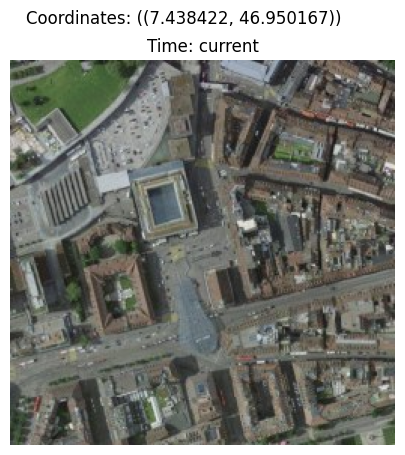

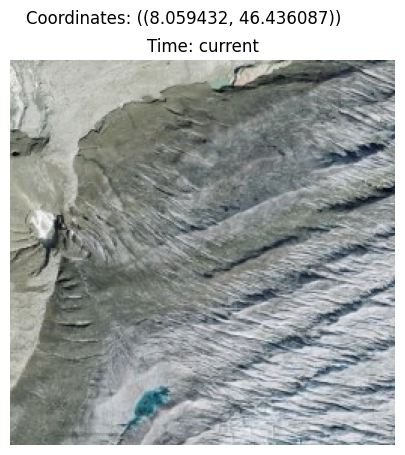

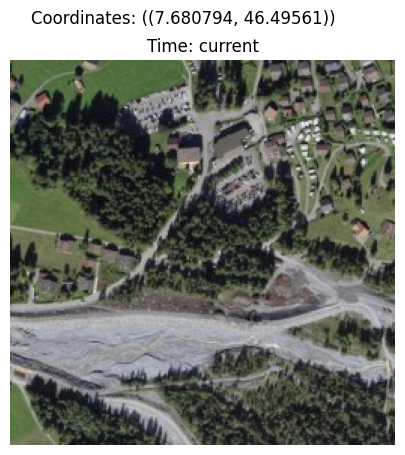

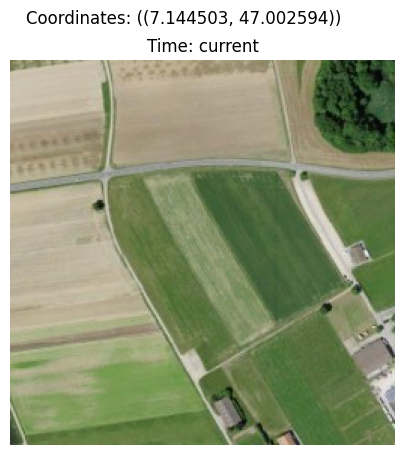

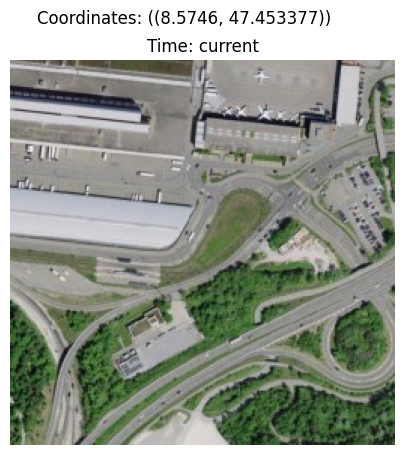

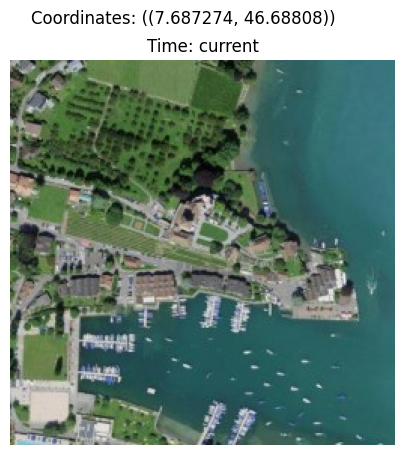

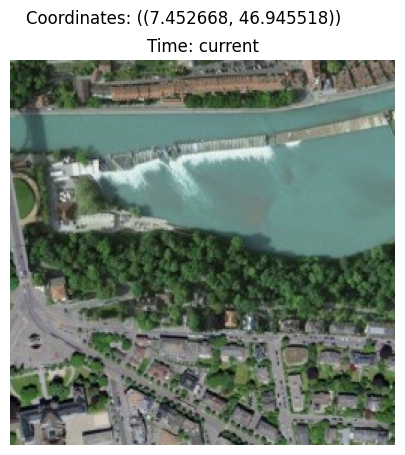

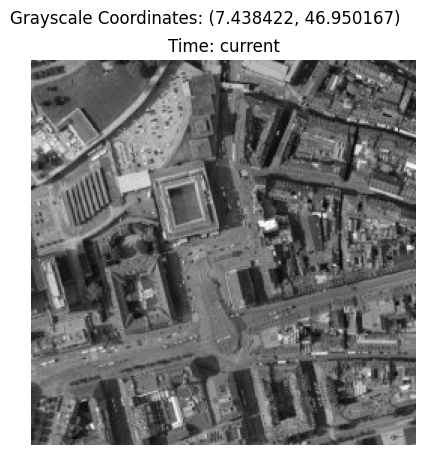

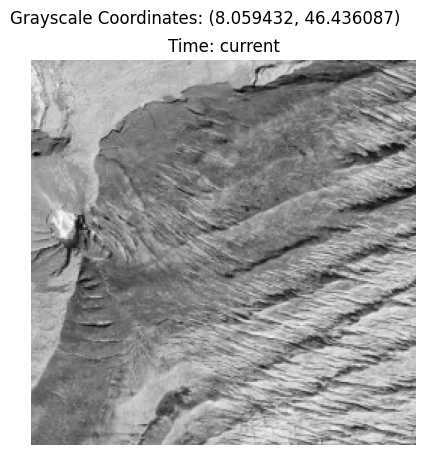

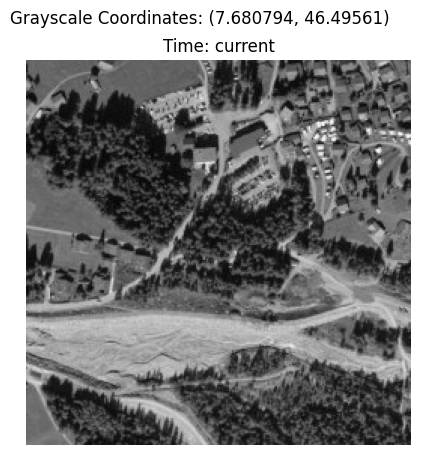

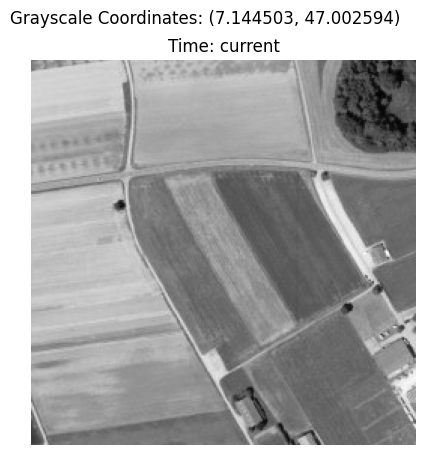

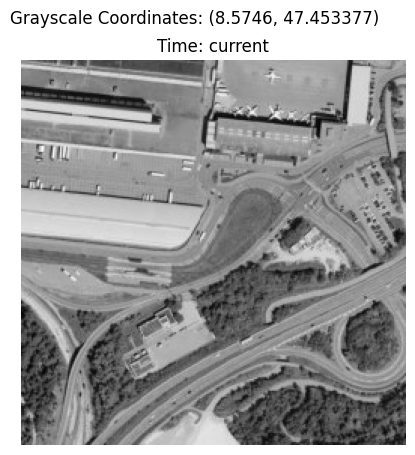

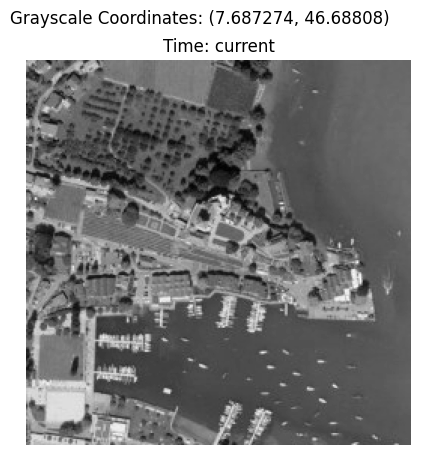

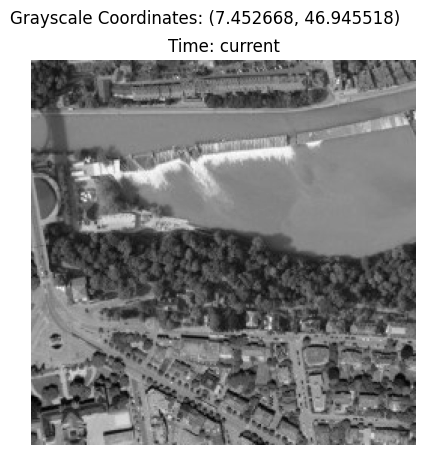

In [15]:
import math
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch

class SwisstopoTileFetcher:
    def __init__(self, coordinates, zoom_level, layer_name="ch.swisstopo.swissimage", times=["current"]):
        self.scheme = "https"
        self.server_name = "wmts.geo.admin.ch"
        self.version = "1.0.0"
        self.layer_name = layer_name
        self.style_name = "default"
        self.tile_matrix_set = "3857"
        self.format_extension = "jpeg"
        self.coordinates = coordinates
        self.zoom_level = zoom_level
        self.times = times
        self.fetched_tiles = {}

    def lat_lon_to_tile_indices(self, longitude, latitude):
        n = 2 ** self.zoom_level
        lat_rad = math.radians(latitude)
        x_tile = int((longitude + 180.0) / 360.0 * n)
        y_tile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
        return x_tile, y_tile

    def fetch_tile(self, longitude, latitude, time):
        x, y = self.lat_lon_to_tile_indices(longitude, latitude)
        url = f"{self.scheme}://{self.server_name}/{self.version}/{self.layer_name}/{self.style_name}/{time}/{self.tile_matrix_set}/{self.zoom_level}/{x}/{y}.{self.format_extension}"
        response = requests.get(url)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            return image
        else:
            print(f"Failed to download tile. Status code: {response.status_code}")
            return None

    def fetch_all_tiles(self):
        for longitude, latitude in self.coordinates:
            self.fetched_tiles[(longitude, latitude)] = []
            for time in self.times:
                image = self.fetch_tile(longitude, latitude, time)
                if image:
                    self.fetched_tiles[(longitude, latitude)].append((time, image))

    def show_tiles(self):
        self.fetch_all_tiles()
        for (longitude, latitude), image_list in self.fetched_tiles.items():
            fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
            fig.suptitle(f"Coordinates: ({longitude, latitude})")
            if len(image_list) == 1:
                axes = [axes]
            for ax, (time, image) in zip(axes, image_list):
                ax.imshow(image)
                ax.set_title(f"Time: {time}")
                ax.axis('off')
            plt.show()

    def get_tiles(self):
        return self.fetched_tiles


def RGB2LAB2(R0, G0, B0):
    R = R0 / 255
    G = G0 / 255
    B = B0 / 255
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    X = 0.449 * R + 0.353 * G + 0.198 * B
    Z = 0.012 * R + 0.089 * G + 0.899 * B
    L = Y
    a = (X - Y) / 0.234
    b = (Y - Z) / 0.785
    return L, a, b


class ConvertRGBToFeedModel(torch.nn.Module):
    def forward(self, img):
        img = np.asanyarray(img)
        sz_x = img.shape[0]
        sz_y = img.shape[1]
        train_imgs = np.zeros((sz_x, sz_y, 2))
        train_input = np.zeros((sz_x, sz_y, 1))
        R1 = np.reshape(img[:, :, 0], (sz_x * sz_y, 1))
        G1 = np.reshape(img[:, :, 1], (sz_x * sz_y, 1))
        B1 = np.reshape(img[:, :, 2], (sz_x * sz_y, 1))
        L, A, B = RGB2LAB2(R1, G1, B1)
        train_input[:, :, 0] = L.reshape((sz_x, sz_y))
        train_imgs[:, :, 0] = np.reshape(A, (sz_x, sz_y))
        train_imgs[:, :, 1] = np.reshape(B, (sz_x, sz_y))
        return (train_input, train_imgs)


def create_grayscale_tiles(fetched_tiles):
    converter = ConvertRGBToFeedModel()
    grayscale_tiles = {}

    for (longitude, latitude), image_list in fetched_tiles.items():
        grayscale_tiles[(longitude, latitude)] = []
        for time, image in image_list:
            L, _ = converter.forward(image)
            grayscale_image = Image.fromarray((L[:, :, 0] * 255).astype(np.uint8))
            grayscale_tiles[(longitude, latitude)].append((time, grayscale_image))

    return grayscale_tiles


# Fetch current images
coordinates = [(7.438422, 46.950167), (8.059432, 46.436087), (7.680794, 46.495610), (7.144503, 47.002594), (8.574600, 47.453377), (7.687274, 46.688080), (7.452668, 46.945518)]
zoom_level = 16
layer_name = "ch.swisstopo.swissimage"
times = ["current"]

fetched_tiles_swissimage_current = SwisstopoTileFetcher(coordinates, zoom_level, layer_name, times)
fetched_tiles_swissimage_current.show_tiles()

# Create the grayscale tiles
grayscale_tiles = create_grayscale_tiles(fetched_tiles_swissimage_current.get_tiles())

# Display grayscale tiles
for (longitude, latitude), image_list in grayscale_tiles.items():
    fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
    fig.suptitle(f"Grayscale Coordinates: ({longitude}, {latitude})")
    if len(image_list) == 1:
        axes = [axes]
    for ax, (time, image) in zip(axes, image_list):
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Time: {time}")
        ax.axis('off')
    plt.show()


# Load Models

In [16]:
url = ("https://drive.usercontent.google.com/download?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&export=download&authuser=0&confirm=t&uuid=8a03b6f8-6f5d-4bc8-a62d-8b0cfc98d2db&at=APZUnTU9WqjmYlQcAGh22O2M8wXI%3A1717452655512")
filename="Hyper_U_Net.h5"

if not os.path.exists(os.path.join(os.curdir, "Hyper_U_Net.h5")):
    path, headers = urlretrieve(url, filename)
# for name, value in headers.items():
#     print(name, value)
model1 = keras.models.load_model(os.path.join(os.curdir, "Hyper_U_Net.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [17]:
!wget -O HyperUnet_retrain_no_augmented_corrected_Adam_ckpt_epoch27_valloss0.0230.keras "https://perritos.myasustor.com:1986/Models/HyperUnet_retrain_no_augmented_corrected_Adam/HyperUnet_retrain_no_augmented_corrected_Adam_ckpt_epoch27_valloss0.0230.keras"

--2024-07-28 14:35:30--  https://perritos.myasustor.com:1986/Models/HyperUnet_retrain_no_augmented_corrected_Adam/HyperUnet_retrain_no_augmented_corrected_Adam_ckpt_epoch27_valloss0.0230.keras
Resolving perritos.myasustor.com (perritos.myasustor.com)... 31.165.170.194
Connecting to perritos.myasustor.com (perritos.myasustor.com)|31.165.170.194|:1986... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381889396 (364M)
Saving to: ‘HyperUnet_retrain_no_augmented_corrected_Adam_ckpt_epoch27_valloss0.0230.keras’

HyperUnet_retrain_n 100%[===================>] 364.20M  11.4MB/s    in 29s     

2024-07-28 14:36:01 (12.4 MB/s) - ‘HyperUnet_retrain_no_augmented_corrected_Adam_ckpt_epoch27_valloss0.0230.keras’ saved [381889396/381889396]



In [18]:
model_filename = "HyperUnet_retrain_no_augmented_corrected_Adam_ckpt_epoch27_valloss0.0230.keras"
model2 = load_model(model_filename)


In [19]:
!wget -O HyperUnet_retrain_augmented_noise_corrected_Adam_ckpt_epoch27_valloss0.0234.keras "https://perritos.myasustor.com:1986/Models/HyperUnet_retrain_augmented_noise_corrected_Adam/HyperUnet_retrain_augmented_noise_corrected_Adam_ckpt_epoch27_valloss0.0234.keras"

--2024-07-28 14:36:07--  https://perritos.myasustor.com:1986/Models/HyperUnet_retrain_augmented_noise_corrected_Adam/HyperUnet_retrain_augmented_noise_corrected_Adam_ckpt_epoch27_valloss0.0234.keras
Resolving perritos.myasustor.com (perritos.myasustor.com)... 31.165.170.194
Connecting to perritos.myasustor.com (perritos.myasustor.com)|31.165.170.194|:1986... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381889396 (364M)
Saving to: ‘HyperUnet_retrain_augmented_noise_corrected_Adam_ckpt_epoch27_valloss0.0234.keras’

HyperUnet_retrain_a 100%[===================>] 364.20M  10.7MB/s    in 36s     

2024-07-28 14:36:45 (9.99 MB/s) - ‘HyperUnet_retrain_augmented_noise_corrected_Adam_ckpt_epoch27_valloss0.0234.keras’ saved [381889396/381889396]



In [20]:
model_filename = "HyperUnet_retrain_augmented_noise_corrected_Adam_ckpt_epoch27_valloss0.0234.keras"
model3 = load_model(model_filename)


In [21]:
models = {"Baseline Model": model1, "No Augmentation": model2, "Augmentation": model3}


# Colorize Images

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image

class ImageColorizer:
    def __init__(self, models, output_dir):
        self.models = models  # Dictionary of models: {model_name: model}
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def LAB22RGB(self, L, a, b):
        a11 = 0.299
        a12 = 0.587
        a13 = 0.114
        a21 = (0.15 / 0.234)
        a22 = (-0.234 / 0.234)
        a23 = (0.084 / 0.234)
        a31 = (0.287 / 0.785)
        a32 = (0.498 / 0.785)
        a33 = (-0.785 / 0.785)

        aa = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
        C0 = np.zeros((L.shape[0], 3))
        C0[:, 0] = L[:, 0]
        C0[:, 1] = a[:, 0]
        C0[:, 2] = b[:, 0]
        C = np.transpose(C0)

        X = np.linalg.inv(aa).dot(C)
        X1D = np.reshape(X, (X.shape[0] * X.shape[1], 1))
        X1D = np.clip(X1D, 0, 1)
        Xr = np.reshape(X1D, (X.shape[0], X.shape[1]))

        Rr = Xr[0][:]
        Gr = Xr[1][:]
        Br = Xr[2][:]

        R = np.uint8(np.round(Rr * 255))
        G = np.uint8(np.round(Gr * 255))
        B = np.uint8(np.round(Br * 255))

        return R, G, B

    def colorize_tiles(self, combined_tiles, plot=False):
        # Iterate through combined_tiles
        for coord, tile_list in combined_tiles.items():
            for time, image in tile_list:
                # Convert PIL image to numpy array
                img_np = np.array(image)

                # Save the original black and white image
                original_output_path = os.path.join(self.output_dir, f"{coord[0]}_{coord[1]}_{time}_original.png")
                io.imsave(original_output_path, img_np)

                # Normalize the L channel
                L = img_np / 255.0
                L = np.expand_dims(L, axis=-1)
                L = np.expand_dims(L, axis=0)

                # Plot the original image if required
                if plot:
                    plt.figure(figsize=(15, 10))
                    plt.subplot(1, len(self.models) + 1, 1)
                    plt.title('Original Black & White Image')
                    plt.imshow(img_np, cmap='gray')
                    plt.axis('off')

                # Colorize the image using each model
                for i, (model_name, model) in enumerate(self.models.items(), start=2):
                    # Predict the color channels
                    predicted = model.predict(L, verbose=0)
                    predicted = np.reshape(predicted, (img_np.shape[0] * img_np.shape[1], 2))
                    a = predicted[:, 0:1]
                    b = predicted[:, 1:2]

                    L_flat = np.reshape(L, (img_np.shape[0] * img_np.shape[1], 1))

                    # Convert LAB to RGB
                    R, G, B = self.LAB22RGB(L_flat, a, b)
                    R = np.reshape(R, (img_np.shape[0], img_np.shape[1]))
                    G = np.reshape(G, (img_np.shape[0], img_np.shape[1]))
                    B = np.reshape(B, (img_np.shape[0], img_np.shape[1]))
                    colorized_img = np.stack((R, G, B), axis=-1)

                    # Save the colorized image with a meaningful name
                    output_path = os.path.join(self.output_dir, f"{coord[0]}_{coord[1]}_{time}_{model_name}.png")
                    io.imsave(output_path, colorized_img)

                    if plot:
                        # Plot the colorized image
                        plt.subplot(1, len(self.models) + 1, i)
                        plt.title(f'{model_name} \n {time}')
                        plt.imshow(colorized_img)
                        plt.axis('off')

                if plot:
                    plt.show()



In [34]:
output_dir = '/content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage'
colorizer = ImageColorizer(models, output_dir)

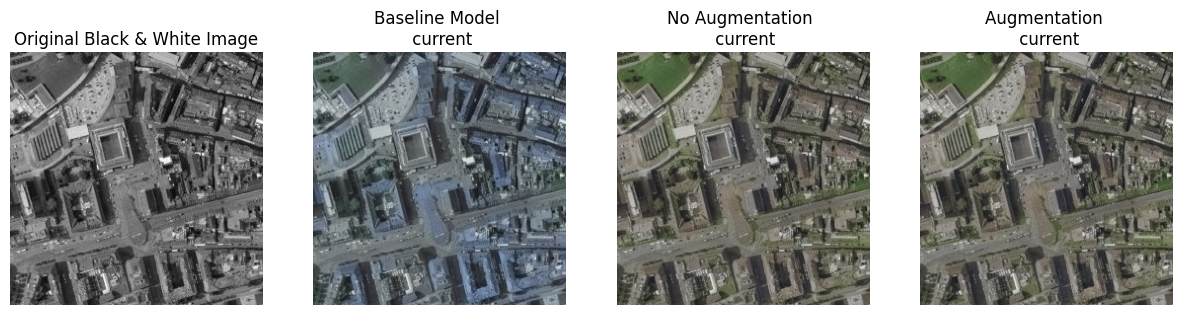

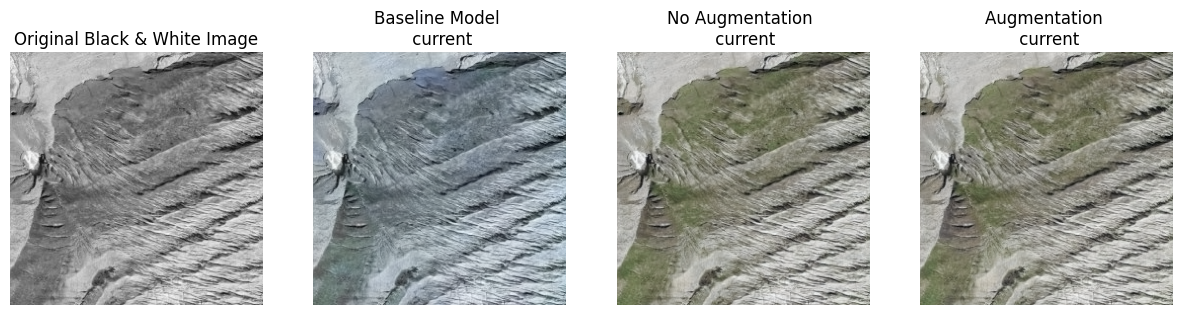

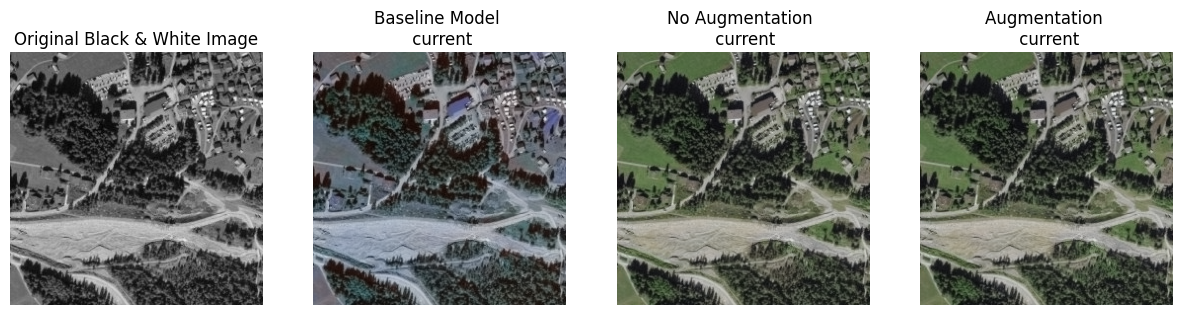

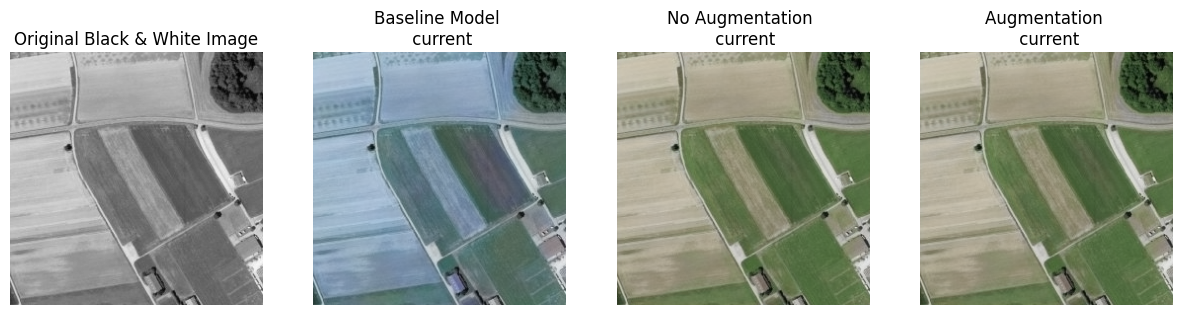

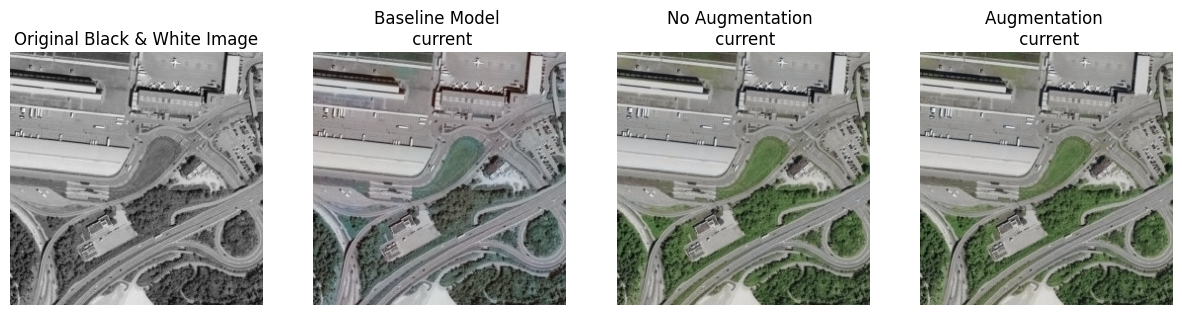

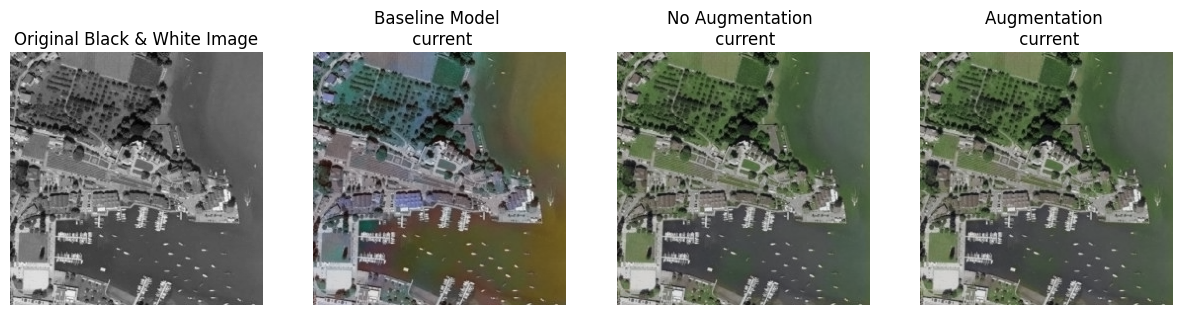

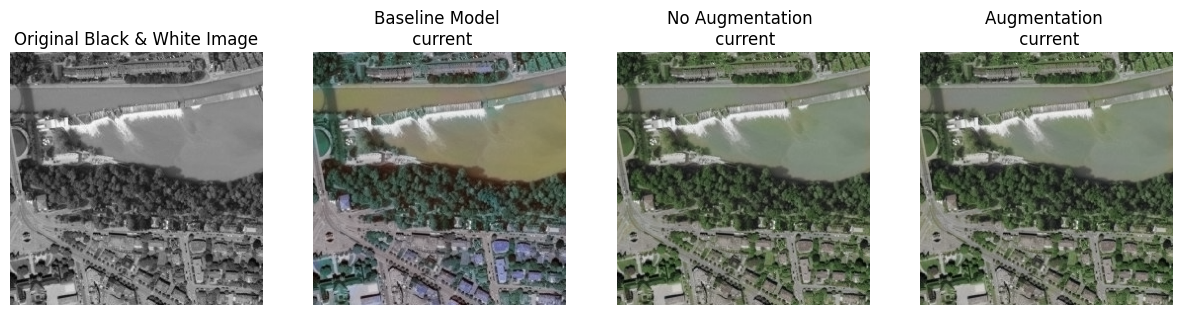

In [35]:
# Colorize the tiles
colorizer.colorize_tiles(grayscale_tiles, plot=True)

In [36]:
os.makedirs(output_dir, exist_ok=True)
for (longitude, latitude), image_list in fetched_tiles_swissimage_current.get_tiles().items():
    for time, image in image_list:
        file_path = os.path.join(output_dir, f"{longitude}_{latitude}_{time}_original.jpeg")
        image.save(file_path)
        print(f"Saved {file_path}")

Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage/7.438422_46.950167_current_original.jpeg
Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage/8.059432_46.436087_current_original.jpeg
Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage/7.680794_46.49561_current_original.jpeg
Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage/7.144503_47.002594_current_original.jpeg
Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage/8.5746_47.453377_current_original.jpeg
Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissimage/7.687274_46.68808_current_original.jpeg
Saved /content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images/swissi